# Example-30: Orbit (effect of transverse shift)

In [1]:
# In this example effect of transverse shifts on closed orbit is illustrated
# Quadrupoles and sextupoles are shifted in transverse planes
# Given shifts variations, effect on orbit at a singe location is computed with MC sampling

In [2]:
# Import

import torch
torch.set_printoptions(linewidth=128)

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['text.usetex'] = True

from twiss import twiss

from ndmap.signature import chop
from ndmap.evaluate import evaluate
from ndmap.pfp import parametric_fixed_point

from ndmap.pfp import clean_point
from ndmap.pfp import chain_point
from ndmap.pfp import matrix

from model.library.drift import Drift
from model.library.quadrupole import Quadrupole
from model.library.sextupole import Sextupole
from model.library.dipole import Dipole
from model.library.line import Line

from model.command.wrapper import wrapper
from model.command.wrapper import group

from model.command.orbit import orbit

In [3]:
# Define simple FODO based lattice using nested lines

DR = Drift('DR', 0.25)
BM = Dipole('BM', 3.50, torch.pi/4.0)

QF_A = Quadrupole('QF_A', 0.5, +0.20)
QD_A = Quadrupole('QD_A', 0.5, -0.19)
QF_B = Quadrupole('QF_B', 0.5, +0.20)
QD_B = Quadrupole('QD_B', 0.5, -0.19)
QF_C = Quadrupole('QF_C', 0.5, +0.20)
QD_C = Quadrupole('QD_C', 0.5, -0.19)
QF_D = Quadrupole('QF_D', 0.5, +0.20)
QD_D = Quadrupole('QD_D', 0.5, -0.19)

SF_A = Sextupole('SF_A', 0.25, +0.75)
SD_A = Sextupole('SD_A', 0.25, -1.25)
SF_B = Sextupole('SF_B', 0.25, +0.75)
SD_B = Sextupole('SD_B', 0.25, -1.25)
SF_C = Sextupole('SF_C', 0.25, +0.75)
SD_C = Sextupole('SD_C', 0.25, -1.25)
SF_D = Sextupole('SF_D', 0.25, +0.75)
SD_D = Sextupole('SD_D', 0.25, -1.25)

FODO_A = Line('FODO_A', [QF_A, DR, SF_A, DR, BM, DR, SD_A, DR, QD_A, QD_A, DR, SD_A, DR, BM, DR, SF_A, DR, QF_A], propagate=True, dp=0.0, exact=False, output=False, matrix=False)
FODO_B = Line('FODO_B', [QF_B, DR, SF_B, DR, BM, DR, SD_B, DR, QD_B, QD_B, DR, SD_B, DR, BM, DR, SF_B, DR, QF_B], propagate=True, dp=0.0, exact=False, output=False, matrix=False)
FODO_C = Line('FODO_C', [QF_C, DR, SF_C, DR, BM, DR, SD_C, DR, QD_C, QD_C, DR, SD_C, DR, BM, DR, SF_C, DR, QF_C], propagate=True, dp=0.0, exact=False, output=False, matrix=False)
FODO_D = Line('FODO_D', [QF_D, DR, SF_D, DR, BM, DR, SD_D, DR, QD_D, QD_D, DR, SD_D, DR, BM, DR, SF_D, DR, QF_D], propagate=True, dp=0.0, exact=False, output=False, matrix=False)

RING = Line('RING', [FODO_A, FODO_B, FODO_C, FODO_D], propagate=True, dp=0.0, exact=False, output=False, matrix=False)

In [4]:
# Set transverse error shifts for quadrupoles and sextupoles

groups = (('dx', ['Quadrupole'], None, None),
          ('dy', ['Quadrupole'], None, None), 
          ('dx', ['Sextupole'], None, None), 
          ('dy', ['Sextupole'], None, None))

ring, table, _ = group(RING, 'FODO_A', 'FODO_D', *groups, alignment=True, root=True)

dx_quad = 100.0E-6*torch.randn(8, dtype=torch.float64)
dy_quad = 100.0E-6*torch.randn(8, dtype=torch.float64)

dx_sext = 200.0E-6*torch.randn(8, dtype=torch.float64)
dy_sext = 200.0E-6*torch.randn(8, dtype=torch.float64)

# Test 

state = torch.tensor(4*[0.0], dtype=torch.float64)
print(ring(state, dx_quad, dy_quad, dx_sext, dy_sext))

tensor([ 1.4136e-04, -1.5725e-05, -6.0736e-04, -2.2900e-06], dtype=torch.float64)


In [5]:
# Compute and test closed orbit

guess = torch.tensor(4*[0.0], dtype=torch.float64)

fp, _ = orbit(RING, guess,  [dx_quad, dy_quad, dx_sext, dy_sext], *groups, alignment=True, limit=8, epsilon=1.0E-12)

print(fp)
print(ring(fp, dx_quad, dy_quad, dx_sext, dy_sext))

tensor([ 1.7361e-04, -5.1339e-06, -2.9886e-04, -3.6663e-05], dtype=torch.float64)
tensor([ 1.7361e-04, -5.1339e-06, -2.9886e-04, -3.6663e-05], dtype=torch.float64)


In [6]:
# Deviation data generation from wrapper

_ = wrapper(RING, *table, verbose=True, alignment=True)
_, data = _(fp, dx_quad, dy_quad, dx_sext, dy_sext)

print(fp)
print(RING(fp, data=data, alignment=True))

tensor([ 1.7361e-04, -5.1339e-06, -2.9886e-04, -3.6663e-05], dtype=torch.float64)
tensor([ 1.7361e-04, -5.1339e-06, -2.9886e-04, -3.6663e-05], dtype=torch.float64)


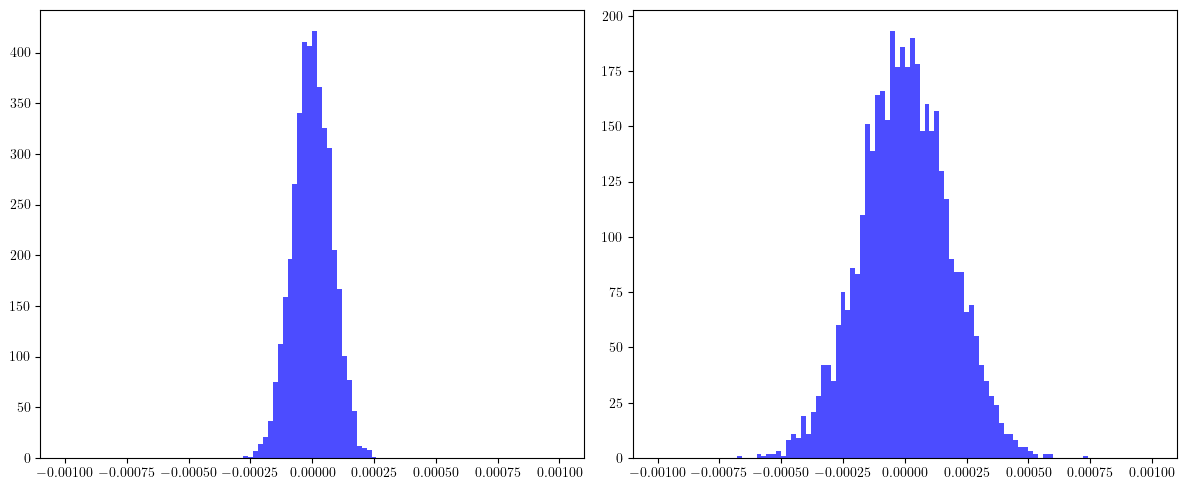

In [7]:
# Orbit sensitivity with MC

def fn(dx_quad, dy_quad, dx_sext, dy_sext):
    guess = torch.tensor(4*[0.0], dtype=torch.float64)
    point, _ = orbit(RING, guess,  [dx_quad, dy_quad, dx_sext, dy_sext], *groups, alignment=True, limit=64, epsilon=None)
    return point

dx_quad = 100.0E-6*torch.randn((2**12, 8), dtype=torch.float64)
dy_quad = 100.0E-6*torch.randn((2**12, 8), dtype=torch.float64)

dx_sext = 200.0E-6*torch.randn((2**12, 8), dtype=torch.float64)
dy_sext = 200.0E-6*torch.randn((2**12, 8), dtype=torch.float64)

cqx, cpx, cqy, cpy = torch.vmap(fn)(dx_quad, dy_quad, dx_sext, dy_sext).T

fig, (ax, ay) = plt.subplots(1, 2, figsize=(12, 5))
ax.hist(cqx.cpu().numpy(), bins=100, range=(-1.0E-3, +1.0E-3), color='blue', alpha=0.7)
ay.hist(cqy.cpu().numpy(), bins=100, range=(-1.0E-3, +1.0E-3), color='blue', alpha=0.7)
plt.tight_layout() 
plt.show()